# feature importance in each Funnel Step (using R)

In [32]:
#0: Import Libraries
library(rpart)
library(rpart.plot)
library(randomForest)
library(htmlTable)
library(Gmisc)
library(rattle)
library(gbm)
library(ROCR)

Loading required package: survival
Loading required package: lattice
Loading required package: splines
Loading required package: parallel
Loaded gbm 2.1.1
Loading required package: gplots

Attaching package: ‘gplots’

The following object is masked from ‘package:stats’:

    lowess



## Funnel step: Exposure

In [2]:
infilename = "Data/derived_data/funnel_steps_20161006.csv"

In [3]:
## load dataframe from csv
fii <- read.csv(infilename)


fii$funnel.exposure = fii$funnel.exposure == 'True'
fii$funnel.enrollment = fii$funnel.enrollment == 'True'
fii$funnel.usage = fii$funnel.usage == 'True'
fii$funnel.usage_basic = fii$funnel.usage_basic == 'True'
fii$funnel.usage_sophisticated = fii$funnel.usage_sophisticated == 'True'
fii$funnel.recent = fii$funnel.recent == 'True'
fii$funnel.longevity = fii$funnel.longevity == 'True'
fii$funnel.frequent = fii$funnel.frequent == 'True'
fii$funnel.retention = fii$funnel.retention == 'True'

summary(fii)

       X            country          age            gender      marital_status 
 Min.   :   0   kenya   :2994   Min.   :15.00   Min.   :1.000   Min.   :1.000  
 1st Qu.: 937   nigeria :6001   1st Qu.:24.00   1st Qu.:1.000   1st Qu.:1.000  
 Median :1874   tanzania:3001   Median :30.00   Median :2.000   Median :3.000  
 Mean   :2099   uganda  :3000   Mean   :33.82   Mean   :1.526   Mean   :2.605  
 3rd Qu.:2811                   3rd Qu.:40.00   3rd Qu.:2.000   3rd Qu.:3.000  
 Max.   :6000                   Max.   :96.00   Max.   :2.000   Max.   :9.000  
                                NA's   :75                                     
 education_level  funnel.exposure funnel.enrollment funnel.usage_basic
 Min.   : 1.000   Mode :logical   Mode :logical     Mode :logical     
 1st Qu.: 3.000   FALSE:6416      FALSE:9063        FALSE:9293        
 Median : 4.000   TRUE :8580      TRUE :5933        TRUE :5703        
 Mean   : 4.402   NA's :0         NA's :0           NA's :0           
 3rd 

In [4]:
names(fii)

[1] "X"                          "country"                   
 [3] "age"                        "gender"                    
 [5] "marital_status"             "education_level"           
 [7] "funnel.exposure"            "funnel.enrollment"         
 [9] "funnel.usage_basic"         "funnel.usage_sophisticated"
[11] "funnel.usage"               "funnel.recent"             
[13] "funnel.longevity"           "funnel.frequent"           
[15] "funnel.retention"

## Mask

In [40]:
names(fii)

[1] "X"                          "country"                   
 [3] "age"                        "gender"                    
 [5] "marital_status"             "education_level"           
 [7] "funnel.exposure"            "funnel.enrollment"         
 [9] "funnel.usage_basic"         "funnel.usage_sophisticated"
[11] "funnel.usage"               "funnel.recent"             
[13] "funnel.longevity"           "funnel.frequent"           
[15] "funnel.retention"

In [39]:
selected_country = 'kenya'

# Retention 
# From Sophisticated Usage
col = 'funnel.retention'
mask = (fii$country==selected_country) & (fii$funnel.usage_sophisticated)

In [7]:
# Apply Mask

x_cols = c('age', 'gender', 'marital_status', 'education_level')
keep_cols = c(x_cols, paste(col))

dat <- fii[mask, keep_cols]

## RPart

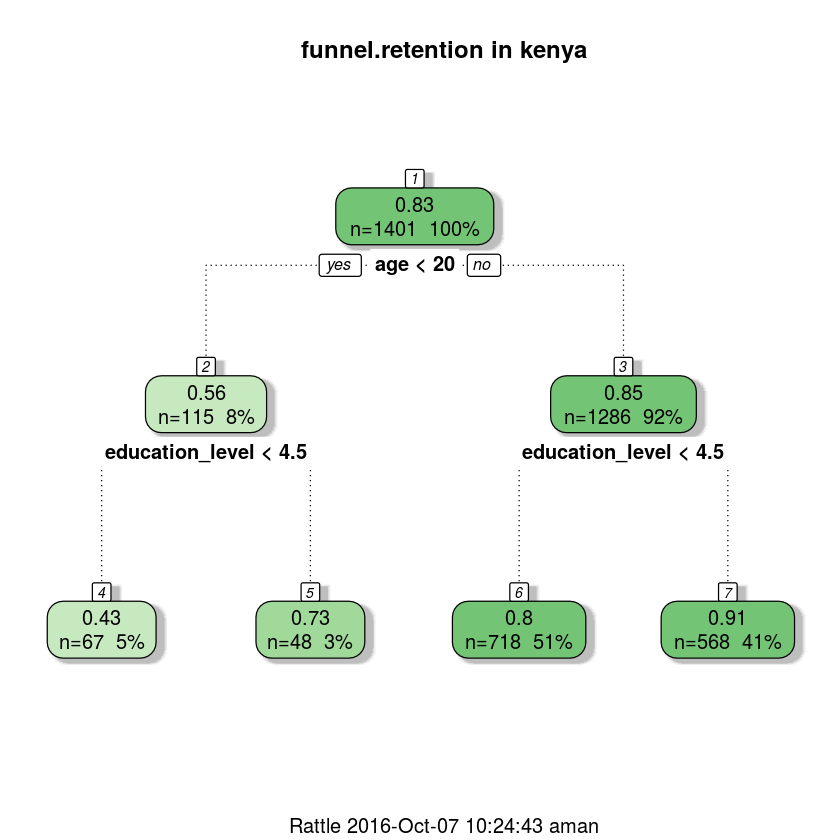

In [8]:
form <- paste(paste(col),"~.")
tree <- rpart(formula = form, 
              data=dat,
#              # cp=0.01
              )

# #options(repr.plot.width=8, repr.plot.height=8)
# #prp(tree, main="hi")
# #rx

#fancyRpartPlot(tree)
p <- fancyRpartPlot(tree, main=paste(paste(col), "in", paste(selected_country)))


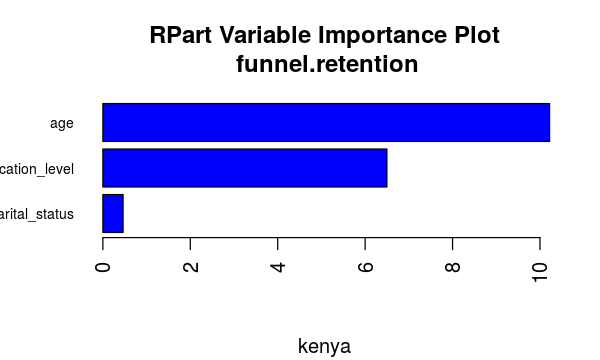

In [9]:
options(repr.plot.width=5, repr.plot.height=3)
barplot(
    sort(tree$variable.importance), 
    col=4, las=2, cex.names = .7, horiz=T, 
    main = paste("RPart Variable Importance Plot\n", col),
    sub=selected_country)



In [10]:
summary(tree)

Call:
rpart(formula = form, data = dat)
  n= 1401 

          CP nsplit rel error    xerror       xstd
1 0.04548254      0 1.0000000 1.0007045 0.04611571
2 0.02012417      1 0.9545175 0.9651280 0.04592629
3 0.01222630      2 0.9343933 0.9469039 0.04443754
4 0.01000000      3 0.9221670 0.9473380 0.04452293

Variable importance
            age education_level  marital_status 
             59              38               3 

Node number 1: 1401 observations,    complexity param=0.04548254
  mean=0.8265525, MSE=0.1433635 
  left son=2 (115 obs) right son=3 (1286 obs)
  Primary splits:
      age             < 20.5 to the left,  improve=0.045482540, (0 missing)
      education_level < 4.5  to the left,  improve=0.029007720, (0 missing)
      gender          < 1.5  to the right, improve=0.009374940, (0 missing)
      marital_status  < 1.5  to the left,  improve=0.003541595, (0 missing)

Node number 2: 115 observations,    complexity param=0.0122263
  mean=0.5565217, MSE=0.2468053 
  left son

## Random Forest

In [11]:
na_mask = mask & (complete.cases(fii[,keep_cols]))

dat <- fii[na_mask, keep_cols]

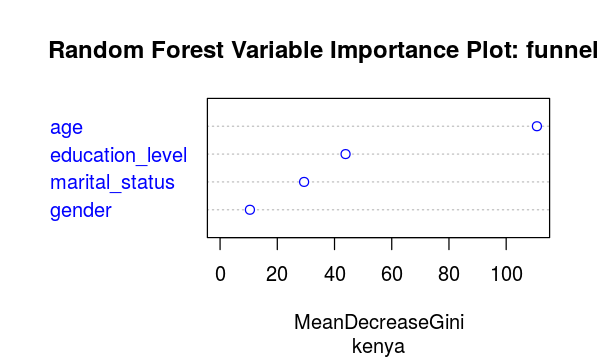

In [12]:

forest <- randomForest(
    x=dat[,x_cols],
    y=as.factor(dat[,col]),
    type=classification,
    #as.factor(col)~.,
    data=dat,
    cp=0.001)

varImpPlot(
    forest, 
    main = paste("Random Forest Variable Importance Plot:", col),
    col=4, 
    sub=selected_country)


In [13]:
summary(forest)

                Length Class  Mode     
call               6   -none- call     
type               1   -none- character
predicted       1401   factor numeric  
err.rate        1500   -none- numeric  
confusion          6   -none- numeric  
votes           2802   matrix numeric  
oob.times       1401   -none- numeric  
classes            2   -none- character
importance         4   -none- numeric  
importanceSD       0   -none- NULL     
localImportance    0   -none- NULL     
proximity          0   -none- NULL     
ntree              1   -none- numeric  
mtry               1   -none- numeric  
forest            14   -none- list     
y               1401   factor numeric  
test               0   -none- NULL     
inbag              0   -none- NULL     

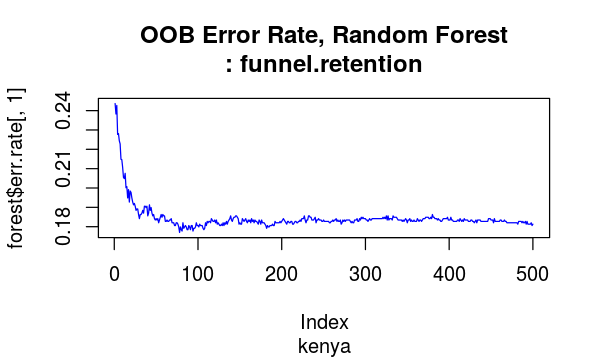

In [14]:
plot(forest$err.rate[,1], type='l',col=4, 
     main = paste("OOB Error Rate, Random Forest\n:", col),
     sub=paste(selected_country),
     )

In [15]:
1-min(forest$err.rate[,1])

[1] 0.8229836

## Logistic Regression

In [16]:
summary(dat[,col])

   Mode   FALSE    TRUE    NA's 
logical     243    1158       0 

In [17]:
summary(as.numeric(dat[,col]))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  1.0000  1.0000  0.8266  1.0000  1.0000 

In [18]:
model <- glm(funnel.retention~., family=binomial(link=logit),
    data=dat)

In [19]:
summary(model)


Call:
glm(formula = funnel.retention ~ ., family = binomial(link = logit), 
    data = dat)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.8089   0.3029   0.5279   0.6776   1.1323  

Coefficients:
                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)     -0.119044   0.407506  -0.292 0.770188    
age              0.026683   0.006879   3.879 0.000105 ***
gender          -0.426814   0.156427  -2.729 0.006362 ** 
marital_status   0.115530   0.061453   1.880 0.060111 .  
education_level  0.281963   0.039310   7.173 7.35e-13 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1292.6  on 1400  degrees of freedom
Residual deviance: 1198.8  on 1396  degrees of freedom
AIC: 1208.8

Number of Fisher Scoring iterations: 5


In [20]:
#This tells us about effect in the units of variable. Let's center and normalize to make the coeffs comparable
scale.dat <- cbind(data.frame(scale(dat[,x_cols]),as.numeric(dat[,col])))
names(scale.dat)[ncol(scale.dat)] <- col #keep original name 
summary(scale.dat)

      age              gender        marital_status    education_level  
 Min.   :-1.5601   Min.   :-1.1416   Min.   :-1.3005   Min.   :-1.3679  
 1st Qu.:-0.7696   1st Qu.:-1.1416   1st Qu.:-0.5423   1st Qu.:-0.6140  
 Median :-0.2954   Median : 0.8753   Median : 0.2159   Median :-0.2370  
 Mean   : 0.0000   Mean   : 0.0000   Mean   : 0.0000   Mean   : 0.0000  
 3rd Qu.: 0.4951   3rd Qu.: 0.8753   3rd Qu.: 0.2159   3rd Qu.: 0.1399  
 Max.   : 3.9730   Max.   : 0.8753   Max.   : 4.7651   Max.   : 3.9094  
 funnel.retention
 Min.   :0.0000  
 1st Qu.:1.0000  
 Median :1.0000  
 Mean   :0.8266  
 3rd Qu.:1.0000  
 Max.   :1.0000  

In [21]:
model <- glm(funnel.retention~., family=binomial(link=logit),
    data=scale.dat)
summary(model)


Call:
glm(formula = funnel.retention ~ ., family = binomial(link = logit), 
    data = scale.dat)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.8089   0.3029   0.5279   0.6776   1.1323  

Coefficients:
                Estimate Std. Error z value Pr(>|z|)    
(Intercept)      1.75829    0.08429  20.859  < 2e-16 ***
age              0.33757    0.08703   3.879 0.000105 ***
gender          -0.21161    0.07756  -2.729 0.006362 ** 
marital_status   0.15237    0.08105   1.880 0.060111 .  
education_level  0.74802    0.10428   7.173 7.35e-13 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1292.6  on 1400  degrees of freedom
Residual deviance: 1198.8  on 1396  degrees of freedom
AIC: 1208.8

Number of Fisher Scoring iterations: 5


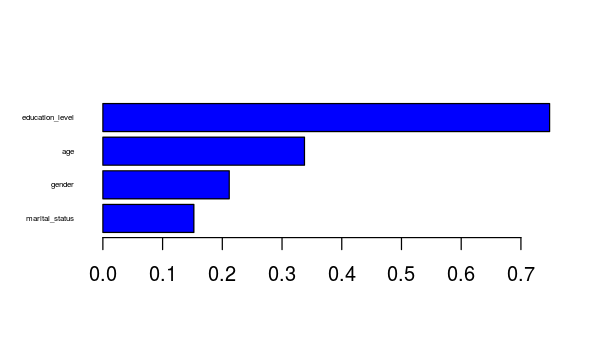

In [22]:
barplot(sort(abs(model$coefficients)[2:5], decreasing=FALSE), col=4, las=1, cex.names=.4, horiz=TRUE)

In [23]:
#education, then age, then gender, then marital status. Age and Education flip-flopped vs. above var imps.

In [24]:
preds <- predict(model, newdata=scale.dat, type='response')

In [25]:
summary(preds)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.5267  0.7646  0.8276  0.8266  0.9024  0.9942 

In [26]:
table(preds>.7, scale.dat[,col])


       
           0    1
  FALSE   56  100
  TRUE   187 1058

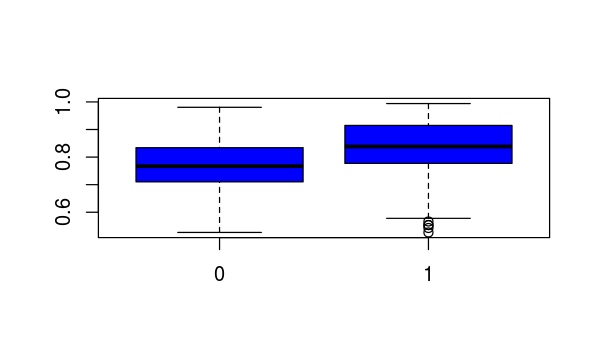

In [27]:
boxplot(preds~scale.dat[,col], col=4)

In [28]:
#pretty lousy model...even before CV.

In [29]:
##Boosted Stumps

In [33]:
model <- gbm(funnel.retention~.,
             data=dat, n.trees=1000,interaction.depth = 1, 
             distribution="adaboost",shrinkage = 0.01, verbose=FALSE, cv.folds=10)

,var,rel.inf
age,age,58.241966
education_level,education_level,30.959295
gender,gender,6.876465
marital_status,marital_status,3.922274


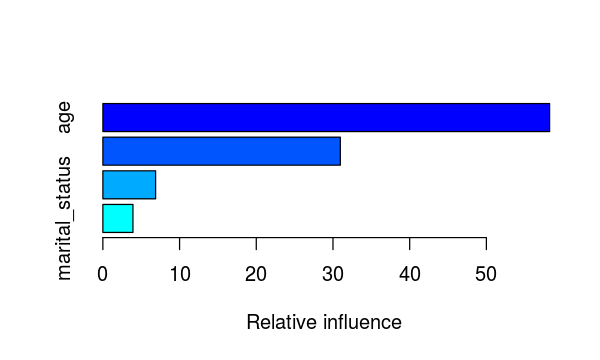

In [34]:
summary(model)

In [35]:
model

gbm(formula = funnel.retention ~ ., distribution = "adaboost", 
    data = dat, n.trees = 1000, interaction.depth = 1, shrinkage = 0.01, 
    cv.folds = 10, verbose = FALSE)
A gradient boosted model with adaboost loss function.
1000 iterations were performed.
The best cross-validation iteration was 662.
There were 4 predictors of which 4 had non-zero influence.

[1] 0.7316805

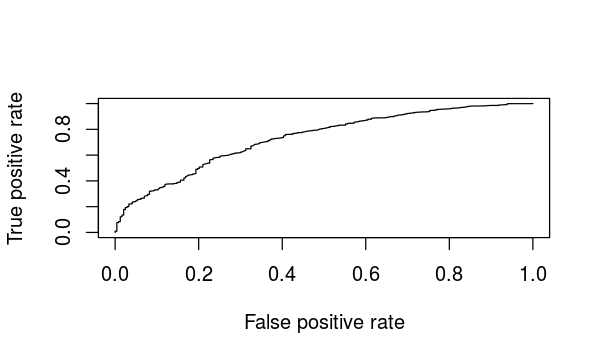

In [36]:
p <- predict.gbm(model, newdata=dat, type="response", n.trees=1000)
pr <- prediction(p, as.numeric(dat[,col]))
prf <- performance(pr, measure = "tpr", x.measure = "fpr")
plot(prf)
auc <- performance(pr, measure = "auc")
auc <- auc@y.values[[1]]
auc

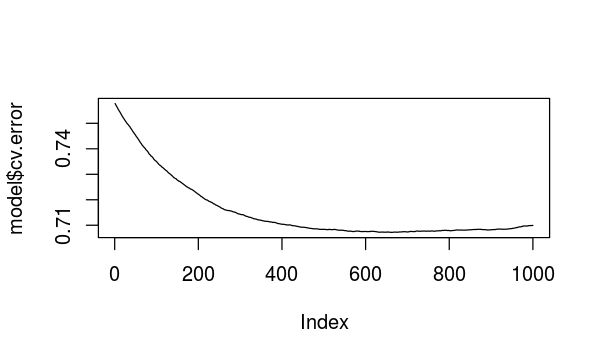

In [37]:
plot(model$cv.error, type='l')

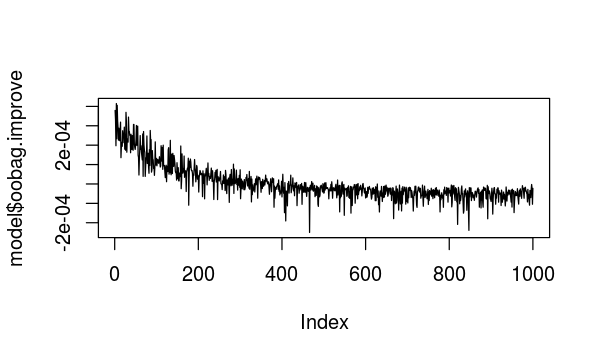

In [38]:
plot(model$oobag.improve, type='l')